In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from tqdm import tqdm
from collections import Counter
import networkx as nx

from helpers.linkage import mutual_information_smooth
import random
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

plt.rcParams['font.family'] = 'Aptos'

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
def plot_random(nc=5,ax=None):
    # Parameters
    n_communities = nc  # number of communities
    sizes = [random.randint(5, 15) for _ in range(nc)]  # sizes of each community
    p_intra = 0.9  # probability of edges within communities
    p_inter = 0.01  # probability of edges between communities

    # Create the probability matrix
    p_matrix = np.full((n_communities, n_communities), p_inter)
    np.fill_diagonal(p_matrix, p_intra)

    # Generate the random graph with communities
    G = nx.stochastic_block_model(sizes, p_matrix)

    # Draw the graph with node colors indicating community membership
    pos = nx.spring_layout(G)  # layout for visualizing the graph
    nx.draw_networkx_edges(G,pos,edge_color='darkgray')

    for node,(x,y) in pos.items():
        ax.scatter([x],[y],s=100,linewidths=1,edgecolors='black',color='white')


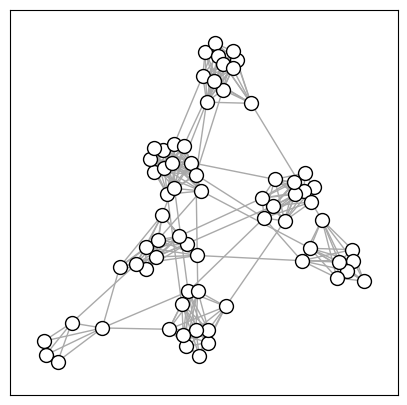

In [117]:
fig, ax = plt.subplots(figsize=(5,5))

plot_random(7,ax=ax)

plt.savefig('figs/example-network-4.svg',bbox_inches='tight',transparent=True)

In [3]:
dists, dat, coltrans, keys, dz = load(zscore_filter=True)
dzm = dz > 0
dists = dists.where(dzm,other=0)

In [39]:
date = pd.Timestamp(year=1974,month=6,day=1)
theta = dists[dists.index == date]
rij, ri, m = mutual_information_smooth(theta.to_numpy())
rij = pd.DataFrame(rij, index=[keys[int(i)] for i in theta.columns], columns=[keys[int(i)] for i in theta.columns])
rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
rij = rij[(rij.s != rij.t) & (rij.pmi > 0.5)]

sizes = dz.loc[theta.index].mean()
sizes = sizes[sizes > 0.03]
rij = rij[(rij.s.isin(sizes.index.astype(int).map(keys))) & (rij.t.isin(sizes.index.astype(int).map(keys)))]

G = nx.from_pandas_edgelist(df = rij, source='s',target='t',edge_attr='pmi')

In [40]:
import adjustText
import matplotlib.patheffects as pe

plt.rcParams['svg.fonttype'] = 'none'

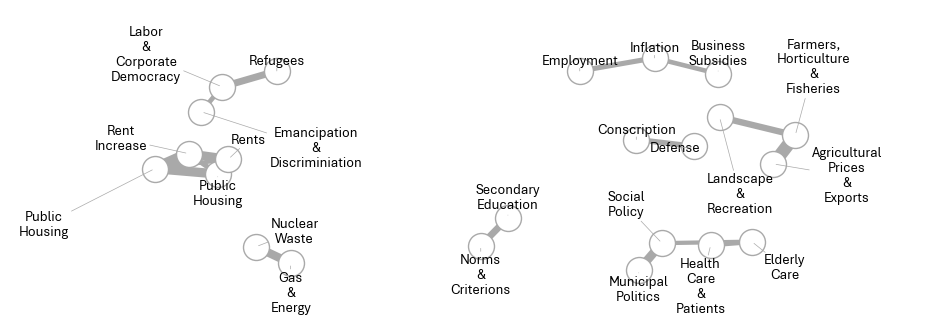

In [58]:
pos = nx.spring_layout(G,iterations=60,k=.75,scale=2)  # layout for visualizing the graph
pos=nx.fruchterman_reingold_layout(G,k=.8,iterations=95)
partition = nx.algorithms.community.louvain_communities(G)
partition = {c:p for c,p in enumerate(partition)}
membership = {item: key for key, value in partition.items() for item in value}

f, ax= plt.subplots(figsize=(12,4))

cmap = sns.color_palette('Greys',len(set(membership.values()))+4)

nx.draw_networkx_edges(G,pos,edge_color='darkgray',alpha=0)
x_min, x_max = plt.gca().get_xlim()
y_min, y_max = plt.gca().get_ylim()

# Calculate the range
x_range = x_max - x_min
y_range = y_max - y_min

# Calculate new limits with 10% expansion
x_min_new = x_min - 0.1 * x_range
x_max_new = x_max + 0.1 * x_range
y_min_new = y_min - 0.1 * y_range
y_max_new = y_max + 0.1 * y_range

# Set new limits
ax.set_xlim(x_min_new, x_max_new)
ax.set_ylim(y_min_new, y_max_new)

posd = dict(pos)

txs = []
for node,(x,y) in pos.items():
    t = '\n'.join([v if v != 'and' else '&' for v in node.split(' ') if len(v) > 1]).title()
    # t = ax.text(x=x,y=y,s=t,path_effects=[pe.withStroke(linewidth=.25, foreground='white')],fontsize=10,color='black')
    t = ax.text(x=x,y=y,s=t,fontsize=10,color='black')
    txs.append(t)
    ax.scatter([x],[y],s=350,color='white',edgecolor='darkgrey')

for s,t,pmi in G.edges(data=True):
    xs,ys = posd[s]
    xt,yt = posd[t]
    ax.plot([xs,xt],[ys,yt],color='darkgrey',zorder=-1,lw=pmi['pmi'] * 6)

adjust_text(txs, force_points=(2,2), force_text=(1,1),autoalign='y',arrowprops=dict(color='darkgrey', arrowstyle='-',linewidth=.5),lim=2500)

plt.axis('off')
plt.savefig('figs/example-annotated-network-cmm.pdf',dpi=400,bbox_inches='tight',transparent=True)